In [190]:
import numpy as np
import os

### functions

In [191]:
def split_covid_data(arr_path, normalize=True):
    covid_data = np.load(arr_path)
    covid_data = covid_data.astype(np.float32)
    
    if normalize: 
        data_mean = np.mean(covid_data, axis=1, keepdims=True)
        data_std = np.std(covid_data, axis=1, keepdims=True)
        covid_data = (covid_data - data_mean) / data_std
        stats_train = (data_mean[:709,:], data_std[:709,:])
        stats_val = (data_mean[709:798, :], data_std[709:798, :])
        stats_test = (data_mean[798:, :], data_std[798:,:])
        stats = (stats_train, stats_val, stats_test)
    else: 
        stats = None
    
    train_data = covid_data[:709,:]
    val_data = covid_data[709:798,:]
    test_data = covid_data[798:, :]

    # reshaping arrays:
    train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1], 1))
    val_data = np.reshape(val_data, newshape=(val_data.shape[0], val_data.shape[1], 1))
    test_data = np.reshape(test_data, newshape=(test_data.shape[0], test_data.shape[1], 1))

    return train_data, val_data, test_data, stats

In [192]:
def rescale_covid_data(data_sample, stats, index):
    data_mean, data_std = stats
    mean, std = data_mean[index], data_std[index]
    data_sample = std * data_sample + mean
    data_sample = data_sample.astype(np.int32)
    return data_sample

In [193]:
covid_path = '../../data/covid_preprocess.npy'
train_data, val_data, test_data, stats = split_covid_data(covid_path)
stats_train, stats_val, stats_test = stats
train_data_unnorm, val_data_unnorm, test_data_unnorm, _ = split_covid_data(covid_path, normalize=False)

In [194]:
sum_test_data = np.sum(test_data_unnorm, axis=1)
print(np.max(sum_test_data))
print(np.argmax(sum_test_data))

20504.0
33


In [195]:
print(sum_test_data[10])
print(sum_test_data[88])
print(sum_test_data[7])
print(sum_test_data[73])

[863.]
[1466.]
[3608.]
[2878.]


In [196]:
print(list(val_data_unnorm[67].reshape(61)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 8.0, 8.0, 8.0, 8.0, 8.0, 15.0, 15.0, 15.0, 15.0, 16.0, 19.0]


In [197]:
#test_data_unnorm[67]

In [198]:
#indexes = [10,88,7,73] #replace 
#indexes = [33,88,7,73]
indexes = [72,2,76,77]
N = 1

In [199]:
smc_t_10_p_path = '../../output/covid_SMC_T/covid_smc_t_10_p'
smc_t_60_p_path = '../../output/covid_SMC_T/covid_smc_t_60_p'

#lstm_path_1 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.1_rnndrop_0.0'
lstm_path_2 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2'
#lstm_path_5 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.5_rnndrop_0.0'

In [200]:
index = 88
mc_drop_path = os.path.join(lstm_path_2, 'mc_dropout_samples_sample_{}.npy'.format(index))
mc_samples = np.load(mc_drop_path)

In [201]:
mc_samples_2 = rescale_covid_data(mc_samples, stats=stats_test, index=index)

In [202]:
def eliminate_neg_values(arr): 
    arr[arr < 0] = 0
    return arr

In [203]:
def get_distrib_means_multistep(smc_t_path, indexes, stats_test, particles=False):
    distribs_10, means_10, particles_10 = [], [], []
    for index in indexes: 

        mean_preds_10_p_path = os.path.join(smc_t_path, 'mean_preds_sample_{}_N_{}_multi.npy'.format(index, N))                              
        distrib_10_p_path = os.path.join(smc_t_path, 'distrib_future_timesteps_sample_{}_N_{}_multi.npy'.format(index, N))
        mean_preds_10 = np.load(mean_preds_10_p_path)
        distrib_10 = np.load(distrib_10_p_path)
            
        mean_preds_rescaled_10 = rescale_covid_data(mean_preds_10, stats=stats_test, index=index)
        distrib_rescaled_10 = rescale_covid_data(distrib_10, stats=stats_test, index=index)
        distrib_rescaled_10 = eliminate_neg_values(distrib_rescaled_10)
        
        if particles: 
            particules_10_p_path = os.path.join(smc_t_path, 'particules_sample_{}_N_{}_multi.npy'.format(index, N))
            particule_10 = np.load(particules_10_p_path)
            particule_10 = rescale_covid_data(particule_10, stats=stats_test, index=index)
            particule_10 = eliminate_neg_values(particule_10)
            particles_10.append(particule_10)
        
        means_10.append(mean_preds_rescaled_10)
        distribs_10.append(distrib_rescaled_10)

    return means_10, distribs_10, particles_10

In [204]:
means_10, distribs_10, particles_10 = get_distrib_means_multistep(smc_t_10_p_path, indexes, stats_test)
means_60, distribs_60, particles_60 = get_distrib_means_multistep(smc_t_60_p_path, indexes, stats_test)

In [205]:
#mc_drop_1_path = os.path.join(lstm_path_1, 'mc_dropout_samples_sample_{}.npy'.format(index))
#mc_drop_2_path = os.path.join(lstm_path_2, 'mc_dropout_samples_sample_{}.npy'.format(index))
#mc_drop_5_path = os.path.join(lstm_path_5, 'mc_dropout_samples_sample_{}.npy'.format(index))

In [206]:
def get_mc_distribs(mc_samples_path, data_unnorm, stats, indexes):
    lstm_preds, mc_distribs, true_labels = [], [], []
    mc_samples = np.load(mc_samples_path)
    for index in indexes:
        true_label = data_unnorm[index, :-1].reshape(60)
        true_labels.append(true_label)
        mc_sample = mc_samples[index,:,:]
        mc_sample = rescale_covid_data(data_sample=mc_sample, stats=stats, index=index)
        mc_sample = np.transpose(mc_sample)
        lstm_pred = np.mean(mc_sample, axis=1)
        lstm_preds.append(lstm_pred)
        mc_sample = mc_sample[40:, :]
        mc_distribs.append(mc_sample)
    return true_labels, lstm_preds, mc_distribs

In [207]:
mc_path_2 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2/mc_dropout_samples_test_data_multi.npy'
mc_path_5 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.5_rnndrop_0.5/mc_dropout_samples_test_data_multi.npy'
true_labels, lstm_means_2, mc_distribs_2 = get_mc_distribs(mc_path_2, test_data_unnorm, stats_test, indexes)
true_labels, lstm_means_5, mc_distribs_5 = get_mc_distribs(mc_path_5, test_data_unnorm, stats_test, indexes)

### confidence intervals computation

In [208]:
def get_distrib_stats(distrib_rescaled):
    distrib_mean = np.mean(distrib_rescaled, axis=1)
    print(distrib_mean[0])
    distrib_std = np.std(distrib_rescaled, axis=1)
    print(distrib_std[0])
    distrib_max = np.max(distrib_rescaled, axis=1)
    distrib_min = np.min(distrib_rescaled, axis=1)
    return distrib_mean, distrib_std, distrib_max, distrib_min

In [209]:
def pad_array(array):
    pad_distrib = np.zeros(shape=60)
    pad_distrib[40:] = array
    return pad_distrib

In [210]:
def get_errors(distrib_mean, distrib_std, distrib_max, distrib_min):
    #pad_distrib_mean = pad_array(distrib_mean)
    #pad_distrib_std = pad_array(distrib_std)
    #lower_bound_min = pad_array(distrib_min)
    #upper_bound_max = pad_array(distrib_max)
    #lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std / (1000**(1/2))
    #upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std / (1000**(1/2))
    lower_bound = distrib_mean - distrib_std
    upper_bound = distrib_mean + distrib_std
    lower_bound = eliminate_neg_values(lower_bound)
    return lower_bound, upper_bound

In [211]:
ints_10, ints_60 = [], []
for distrib_10, distrib_60 in zip(distribs_10, distribs_60):
    mean_10, std_10, max_10, min_10 = get_distrib_stats(distrib_10)
    mean_60, std_60, max_60, min_60 = get_distrib_stats(distrib_60)
    lb_min_10, lb_max_10 = get_errors(mean_10, std_10, max_10, min_10)
    lb_min_60, lb_max_60 = get_errors(mean_60, std_60, max_60, min_60)
    int_10 = [lb_min_10, lb_max_10]
    int_60 = [lb_min_60, lb_max_60]
    #min_max_10 = [pad_array(mean_10)-pad_array(std_10), pad_array(mean_10) + pad_array(std_10)]
    #min_max_60 = [pad_array(mean_60)-pad_array(std_60), pad_array(mean_60) + pad_array(std_60)]
    ints_10.append(int_10)
    ints_60.append(int_60)

53.543
17.10175871072914
46.886
15.799208967540114
156.409
20.964677889249813
137.891
22.230409780298697
18.877
5.208250282004505
18.958
5.290012854426726
2.791
3.5965704497479263
3.64
5.5902057207226274


In [212]:
ints_lstm_5 = []
for distrib in mc_distribs_5:
    mc_mean, mc_std, mc_max, mc_min = get_distrib_stats(distrib)
    lb, ub = get_errors(mc_mean, mc_std, mc_max, mc_min)
    inter = [lb , ub]
    ints_lstm_5.append(inter)

46.052
3.187051301752137
132.2
7.836836096282732
18.839
1.5320179502864828
0.072
0.2980201335480538


In [213]:
import matplotlib.pyplot as plt

In [217]:
def plot_inference_smc_t(title, true_labels, lstm_means, ints_lstm, means_10, ints_10, means_60=None, ints_60=None):
    fig, ax = plt.subplots(figsize=(16,10))
    x = np.linspace(1,60,60)
    x_20 = np.linspace(40,60,20)
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
    number_samples = len(means_10)
    states = ['Unassigned - MARYLAND', 'Fairfax - VIRGINIA', 'Unassigned - NEBRASKA', 'Unassigned - NEVADA'][:number_samples]
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange'][:number_samples]
    
    for i, (st, col) in enumerate(zip(states, colors)):
        ax.plot(x, true_labels[i], '-', color='tab:grey', lw=2)
        ax.plot(x, means_10[i], 'o', linestyle='dashed', color=col, label='SMC-T mean preds, {}'.format(st))
        ax.fill_between(x_20, ints_10[i][0], ints_10[i][1], alpha=0.2, color=col)
        if means_60 is not None:
            ax.plot(x, means_60[i], '-', linestyle='dotted', color=col, label='mean predicted data, {}'.format(st))
            ax.fill_between(x_20, ints_60[i][0], ints_60[i][1], alpha=0.5, color=col)
        if lstm_means is not None:
            ax.plot(x, lstm_means[i], 'x', linestyle='dotted', color=col, label='lstm mean preds, {}'.format(st))
            ax.fill_between(x_20, ints_lstm[i][0], ints_lstm[i][1], alpha=0.5, color='tab:grey', hatch=r"//")
    
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    ax.set_title(title, fontdict=font)
    ax.legend(fontsize=14)
    
    return fig, ax

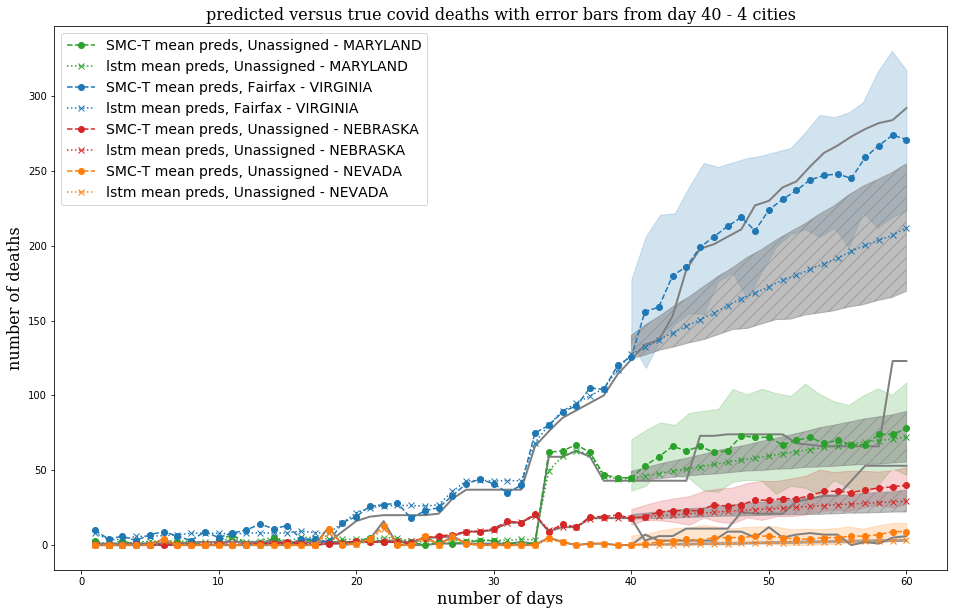

In [218]:
title = "predicted versus true covid deaths with error bars from day 40 - 4 cities"
#fig, ax = plot_inference_smc_t(title, true_labels, None, None, means_10, ints_10, means_60, ints_60)
fig, ax = plot_inference_smc_t(title, true_labels, lstm_means_5, ints_lstm_5, means_10, ints_10)

In [220]:
save_path = 'smc_t_10p_lstm_05_samples_{}_{}_{}_{}'.format(indexes[0], indexes[1], indexes[2], indexes[3])
fig_path = os.path.join(smc_t_10_p_path, save_path)
fig.savefig(fig_path)

### adding mc dropout

In [538]:
def plot_mc_dropout(title, x, true_labels, lstm_means, ints_lstm):
    fig, ax = plt.subplots(figsize=(16,10))
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
    #states = ['VA(1)', 'MI', 'VA(2)', 'MA']
    states = ['VA(1)']
    colors = ['tab:green']
    for i, (st, col) in enumerate(zip(states, colors)):
        ax.plot(x, true_labels[i], '-', color='tab:grey', lw=2)
        ax.plot(x, lstm_means[i], 'x', linestyle='dotted', color=col, label='lstm mean preds, {}'.format(st))
        ax.fill_between(x, ints_lstm[i][0], ints_lstm[i][1], alpha=0.2, color='tab:grey', hatch=r"//")
    
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    ax.set_title(title, fontdict=font)
    ax.legend(fontsize=14)
    return fig, ax

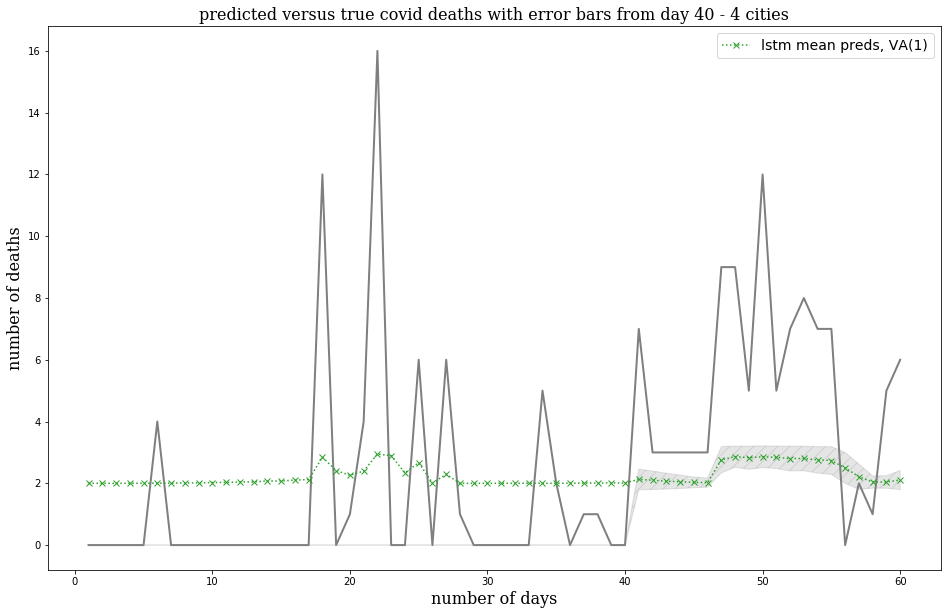

In [540]:
fig, ax = plot_mc_dropout(title, x, true_labels, lstm_preds, ints_lstm)

In [342]:
fig_path = os.path.join(lstm_out_path_1, 'lstm_preds_sample_{}'.format(index))
fig.savefig(fig_path)

NameError: name 'lstm_out_path_1' is not defined